# Installing Packages

In [ ]:
!pip install -U torchtext==0.6.0

# Importing Required Libraries

In [1]:
import torch
from torchtext import data, datasets
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, LabelField, BucketIterator
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [3]:
SEED = 4444

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
FIELD = Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm')

LABEL = LabelField()

# Splitting the data

In [5]:
train_data, test_data = datasets.TREC.splits(FIELD, LABEL, fine_grained=False)

In [6]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3816
Number of validation examples: 1636
Number of testing examples: 500


In [8]:
MAX_VOCAB_SIZE = 25000 # excluding <pad> and <unk> token
FIELD.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors="glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [9]:
print(f"Unique tokens in FIELD vocabulary: {len(FIELD.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in FIELD vocabulary: 7518
Unique tokens in LABEL vocabulary: 6


# Model Definition

In [10]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_filters, filter_sizes, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = num_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, text):                                                          # [input] = [seq_len, batch_size]
        text = text.permute(1, 0)                                                     # [input] = [batch_size, seq_len]
        embedded = self.embedding(text)                                               # [embedded] = [batch_size, seq_len, emb_dim]
        embedded = embedded.unsqueeze(1)                                              # [embedded] = [batch_size, 1, seq_len, emb_dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]           # [conv] = [batch_size, num_filters, seq_len - filter_sizes[n]]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]    # [pooled] = [batch_size, num_filters]
        output = self.dropout(torch.cat(pooled, dim = 1))                             # [output] = [batch_size, num_filters * len(filter_sizes)]
        return self.fc(output)

In [11]:
def batch_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# Training and Evaluation Functions

In [12]:
def Train(model, iterator, optimizer, criterion): 
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        inp = batch.text
        label = batch.label       
        predictions = model(inp)
        loss = criterion(predictions, label)
        acc = batch_accuracy(predictions, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def Evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            inp = batch.text
            label = batch.label   
            predictions = model(inp).squeeze(1)
            loss = criterion(predictions, label)
            acc = batch_accuracy(predictions, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Data Iterators, Hyperparameters and Model Initialization

In [14]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, device = device)

In [15]:
VOCAB_SIZE = len(FIELD.vocab) # dimension of one-hot vector / vocabulary
EMB_DIM = 100 # dimensions of word embeddings
NUM_FILTERS = 100 # number of filters in CNN
FILTER_SIZES = [2,3,4] # filter sizes of CNN
OUTPUT_DIM = len(LABEL.vocab) # dimensions of output
DROPOUT = 0.5 

NUM_EPOCHS = 10
LR = 0.001

In [16]:
model = CNN(VOCAB_SIZE, EMB_DIM, NUM_FILTERS, FILTER_SIZES, OUTPUT_DIM, FIELD.vocab.stoi[FIELD.pad_token])

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 843,906 trainable parameters


# Training

In [19]:
import time

def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
print(f"Learning Rate: {LR}, Number of Filters: {NUM_FILTERS}, Filter Sizes: {FILTER_SIZES}")
train_losses = []
valid_losses = []
min_losses = [float('inf'), float('inf')]

start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    
    train_loss, train_acc = Train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_loss, valid_acc = Evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)

    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(model.state_dict(), 'CNN.pt')

    elapsed_time = Epoch_time(start_time, time.time())
    print(f"Time taken for epoch {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
    start_time = time.time()
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Training Accuracy: {train_acc*100:.2f} %| Validation Accuracy: {valid_acc*100:.2f} %")

print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Number of Filters: 100, Filter Sizes: [2, 3, 4]
Time taken for epoch 1: 0m 17s
Training Loss: 1.4261 | Validation Loss: 1.0630
Training Accuracy: 43.17 %| Validation Accuracy: 62.21 %
Time taken for epoch 2: 0m 14s
Training Loss: 0.9428 | Validation Loss: 0.8337
Training Accuracy: 64.54 %| Validation Accuracy: 70.10 %
Time taken for epoch 3: 0m 14s
Training Loss: 0.7243 | Validation Loss: 0.7207
Training Accuracy: 73.87 %| Validation Accuracy: 74.49 %
Time taken for epoch 4: 0m 14s
Training Loss: 0.5866 | Validation Loss: 0.6712
Training Accuracy: 79.45 %| Validation Accuracy: 74.23 %
Time taken for epoch 5: 0m 15s
Training Loss: 0.4986 | Validation Loss: 0.6235
Training Accuracy: 83.14 %| Validation Accuracy: 76.77 %
Time taken for epoch 6: 0m 14s
Training Loss: 0.3997 | Validation Loss: 0.5953
Training Accuracy: 87.04 %| Validation Accuracy: 77.98 %
Time taken for epoch 7: 0m 14s
Training Loss: 0.3328 | Validation Loss: 0.5735
Training Accuracy: 89.69 %| Validat

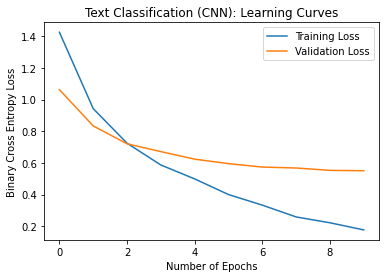

In [27]:
plt.title("Text Classification (CNN): Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()

# Testing

In [23]:
model.load_state_dict(torch.load('CNN.pt'))

test_loss, test_acc = Evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Loss: 0.3947
Test Accuracy: 84.90%


# Sampling

In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_class(model, text, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(text)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [FIELD.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [42]:
print(LABEL.vocab.itos)

['ENTY', 'HUM', 'DESC', 'NUM', 'LOC', 'ABBR']


In [52]:
pred_class = predict_class(model, "What does CNN stand for?")
print(f'Predicted class is: {LABEL.vocab.itos[pred_class]}')

Predicted class is: ABBR


In [53]:
pred_class = predict_class(model, "How long did it take to train an epoch?")
print(f'Predicted class is: {LABEL.vocab.itos[pred_class]}')

Predicted class is: NUM


In [57]:
pred_class = predict_class(model, "What is the model of GPU used?")
print(f'Predicted class is: {LABEL.vocab.itos[pred_class]}')

Predicted class is: DESC
